# Comparison of Robot's movement capacity aware real-time trajectory planning in Cartesian Space with TOPPRA 

In [1]:
%matplotlib widget

import roboticstoolbox as rt
import numpy as np
import pinocchio 
import time
import matplotlib.pyplot as plt

from planning_utils import *

## Defining the initial robot's pose

In [2]:
panda = rt.models.DH.Panda()
# initial pose
q0= np.array([0 ,0,0,   -1.6, 0,    1.57, 0])
panda.q = q0

## Defining the Cartesian space path

In [3]:
# trajecoty length
traj_length = 0.4

# find the initial and final pose
# in a random manner
# with the distance of `traj_length` 
X_init, X_final = find_random_poses_with_distance(robot=panda, distance=traj_length, q0=q0 )
print('initial point:\t', X_init.t)
print('final point:\t',X_final.t)
print('traj length:\t',traj_length)

searching
not attainable final
initial point:	 [ 0.6309245  -0.05266971  0.36295855]
final point:	 [0.43712742 0.09812952 0.04720186]
traj length:	 0.4


## Visualise the path

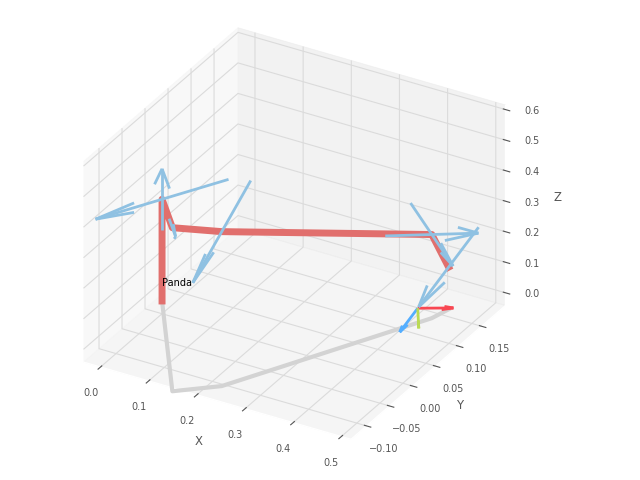

In [7]:
fig = panda.plot(panda.ikine_LM(X_final,joint_limits=True).q)
ax = fig.ax
x3d = np.vstack((X_init.t, X_final.t))
ax.plot(x3d[:,0],x3d[:,1],x3d[:,2])

## Defining the robot's movement capacity limits 

In [8]:
# limits
# joint space
q_min, q_max  = panda.qlim
dq_max = rt.models.URDF.Panda().qdlim[:7]
dq_min = -dq_max
ddq_max = np.array([15,7.5,10,12.5,15,20,20])
ddq_min = -ddq_max
dddq_max = np.array([7500, 3750, 5000,6250,7500,10000,10000])
dddq_min = -dddq_max
t_max = np.array([87, 87, 87, 87, 20, 20, 20])
t_min = -t_max

# cartesian space
dddx_max = np.array([6500.0,6500.0,6500.0])
dddx_min = -dddx_max
ddx_max = np.array([13.0,13,13])
ddx_min = -ddx_max
dx_max = np.array([1.7,1.7,1.7])
dx_min = -dx_max

limits = {'q_min':q_min, 'q_max':q_max, 'dq_max': dq_max, 'ddq_max':ddq_max, 'dddq_max':dddq_max, 't_max':t_max, 'dx_max':dx_max, 'ddx_max':ddx_max, 'dddx_max':dddx_max }

## Defining the capacity scaling factor

In [9]:
#capacity scaling
scale  = 0.5
print('capacity scale:\t',scale)

capacity scale:	 0.5


## Calculate the trajecoty using the proposed method

In [10]:
options = {
            'downsampling_ratio':10.0, # heuristic to avoid oscilation - it corresponds to the downsampling factor in miliseconds (set to 1.0 to disable it)
            'clamp_min_accel':True, # heuristic to avoid overshoot (if disabled the overshoot will be higher)
            'calculate_limits':True # calculate the movement capacity limits in real-time (if set to False the planned trajectory corresponds to the offline TAP planning)
          }
data = compute_capacity_aware_trajectory(X_init, X_final, lims=limits, scale=scale, options=options, robot=panda, q0 = q0)

t	0
Calculation duration: 3.9131083488464355 [s]
Trajectory duration: 1.0500 [s]


## Calculate the trajecoty using TOPPRA

In [11]:
# calculate the joint space path and find the time-optimal trajecoty using TOPPRA
ts_sample, qs_sample, qds_sample, qdds_sample = caclulate_toppra_trajectory(X_init, X_final, robot=panda, q0=q0, d_waypoint=0.05, lims=limits, scale = scale)

# simulate the calculated trajectory by toppra
data_top = simulate_toppra(X_init, X_final, ts_sample, qs_sample,qds_sample,qdds_sample, q0=q0, robot=panda, lims=limits, scale = scale, options=options)

traj length: 0.4, number of waypoints: 8
calculation waypoints
Waypoints calculation time: 0.8737702369689941
TOPPRA calculation time: 0.06819486618041992
Waypoints+TOPPRA calculation time: 0.9421207904815674
simulating trajectory
TOPPRA trajecotry simulation time 4.551605701446533


In [12]:
print("TOPPRA trajectory duration:{}".format(ts_sample[-1]))
print("ours trajectory duration:{}".format(data.t_ruckig[-1]))

TOPPRA trajectory duration:1.052
ours trajectory duration:1.05


## Visualisation of the obtained trajectories 


Visualising the time evalution of trajecotyr variables
- $s$: scalar position on the trajectory
- $\dot{s}$: scalar velocity on the trajectory
- $\ddot{s}$: scalar acceleration on the trajectory
- $\dddot{s}$: scalar jerk on the trajectory

Additionally for both our approach and TOPPRA the state dependent robot's movement capacity is calculated and visualised in black dashed lines

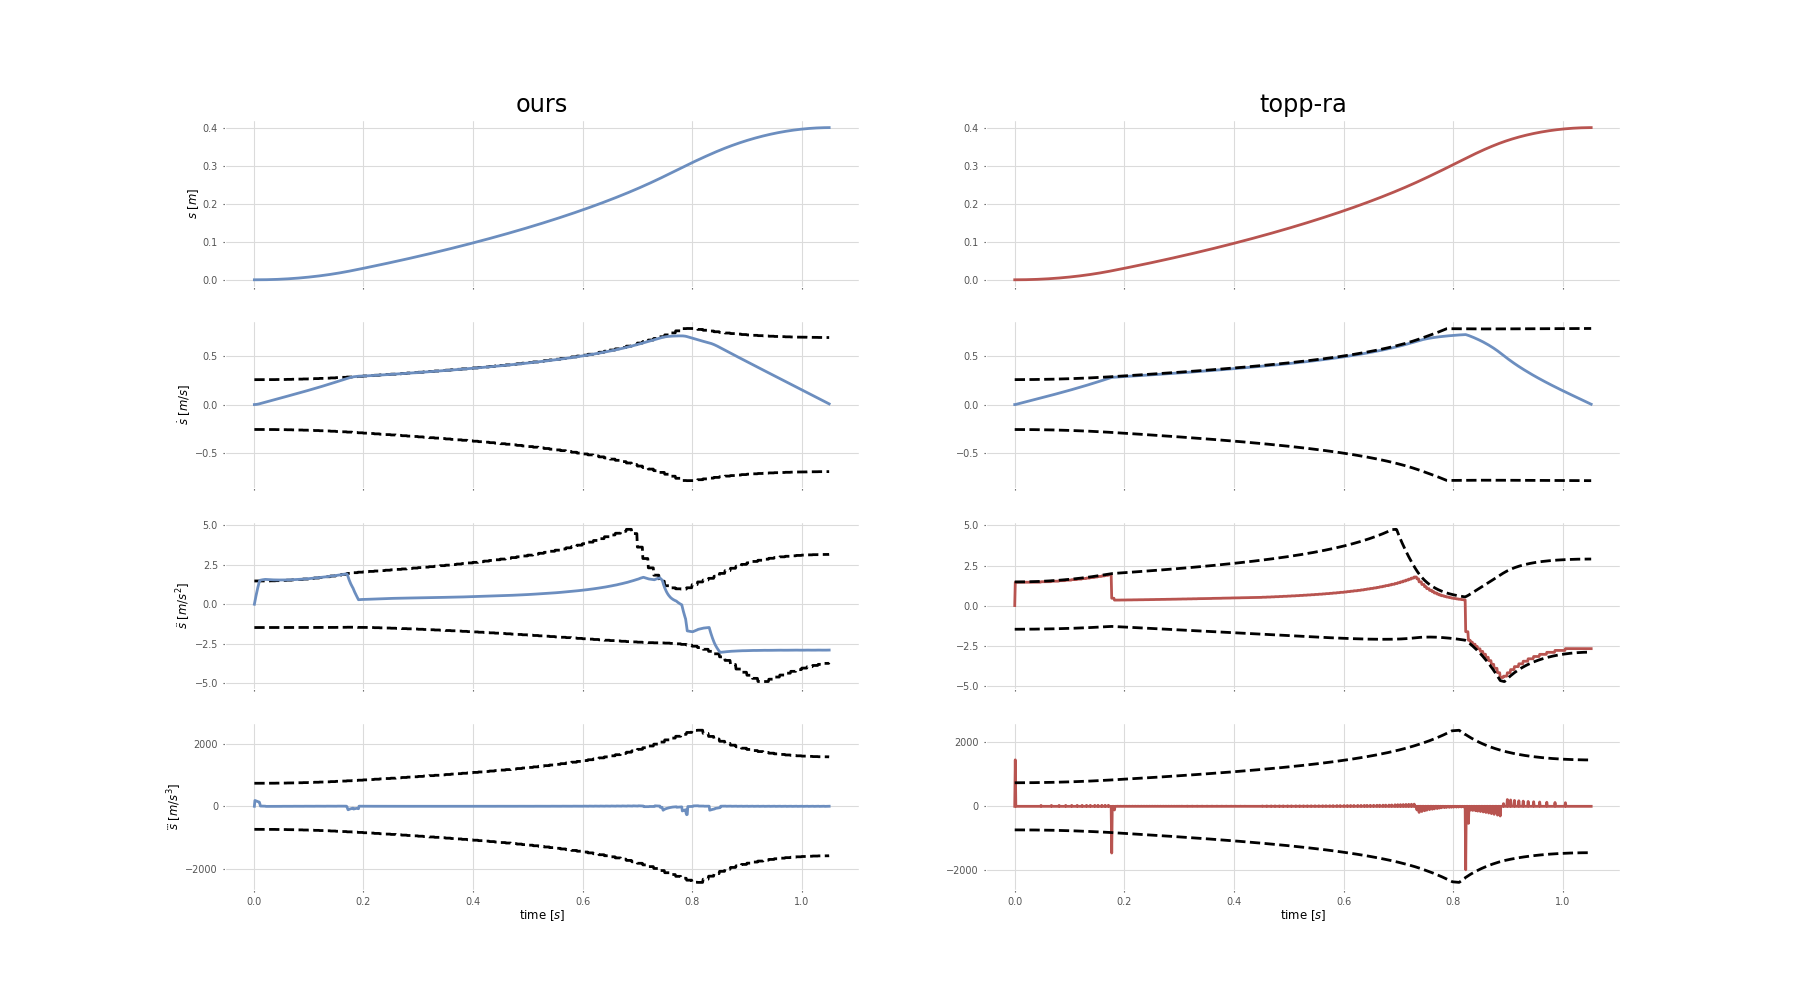

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [13]:
plt.rcParams['axes.facecolor'] = 'white'
fig, axs = plt.subplots(4, 2, sharex=True, figsize=[18, 10])

linewidth = 2
fontsize = 12
plt.rcParams.update({'font.size': fontsize,'xtick.color':'black', 'ytick.color':'black'})
axs[0,0].plot(data.t_ruckig[1:],data.x_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[0,1].plot(data_top.t_toppra, data_top.x_top,'#B85450', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_max_list[1:],'k--', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_min_list[1:],'k--', linewidth=linewidth)
axs[1,0].plot(data.t_ruckig[1:],data.dx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra, data_top.dx_top,'#6C8EBF', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra,data_top.ds_max_list,'k--', linewidth=linewidth)
axs[1,1].plot(data_top.t_toppra,data_top.ds_min_list,'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_max_list[1:],'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_min_list[1:],'k--', linewidth=linewidth)
axs[2,0].plot(data.t_ruckig[1:],data.ddx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra, data_top.ddx_top,'#B85450', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra,data_top.dds_max_list,'k--', linewidth=linewidth)
axs[2,1].plot(data_top.t_toppra,data_top.dds_min_list,'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_max_list[1:],'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_min_list[1:],'k--', linewidth=linewidth)
axs[3,0].plot(data.t_ruckig[1:],data.dddx_q_list[1:],'#6C8EBF', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra, data_top.dddx_top,'#B85450', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra,data_top.ddds_max_list,'k--', linewidth=linewidth)
axs[3,1].plot(data_top.t_toppra,data_top.ddds_min_list,'k--', linewidth=linewidth)


axs[0,0].set_title("ours")
axs[0,0].set_ylabel('${s}$ $[m]$',color="black")
axs[1,0].set_ylabel('$\dot{s}$ $[m/s]$',color="black")
axs[2,0].set_ylabel('$\ddot{s}$ $[m/s^2]$',color="black")
axs[3,0].set_ylabel('$\dddot{s}$ $[m/s^3]$',color="black")
axs[3,0].set_xlabel('time $[s]$',color="black")
axs[3,1].set_xlabel('time $[s]$',color="black")
axs[0,1].set_title("topp-ra")
plt.show()
plt.legend()

## Visualising the comparrison 

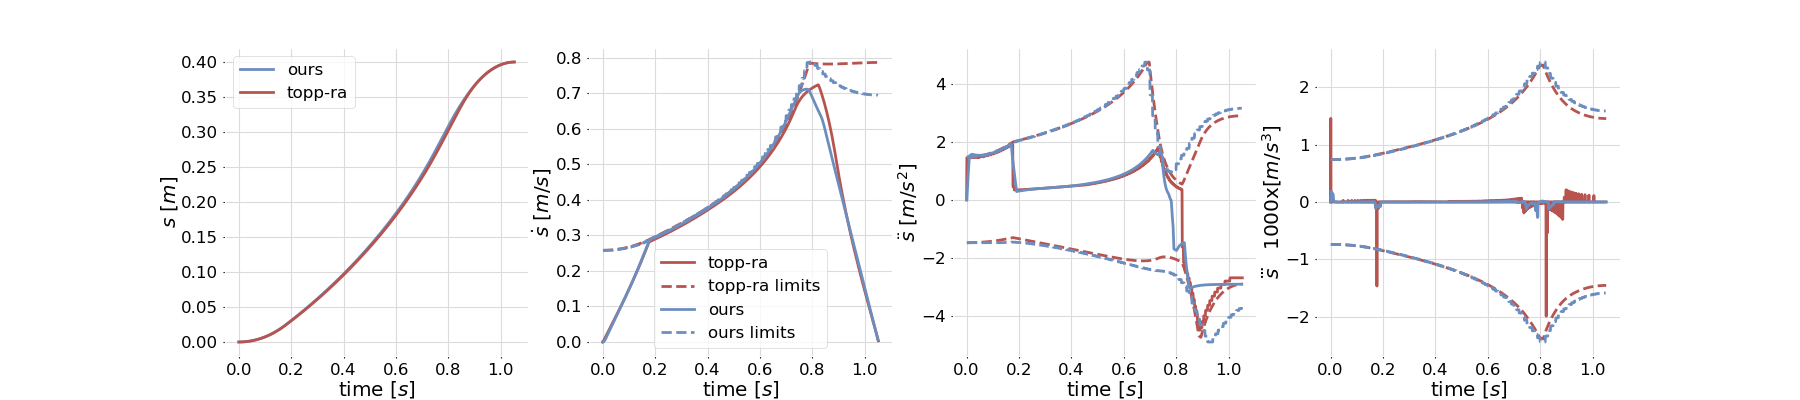

In [14]:
fig, axs = plt.subplots(1,4, sharex=True,figsize=[18, 4])
plt.rcParams['axes.facecolor'] = 'white'
linw = 2
plt.rcParams.update({'font.size': 12,'xtick.color':'black', 'ytick.color':'black'})

axs[0].plot(data.t_ruckig[1:],data.x_list[1:],linewidth=linw,color='#6C8EBF',label='ours')
axs[0].plot(ts_sample,data_top.x_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[0].set_xlabel('time $[s]$',color="black")
axs[0].set_ylabel('${s}$ $[m]$',color="black")
axs[0].legend(loc='best')

axs[1].plot(data_top.t_toppra, data_top.dx_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[1].plot(data_top.t_toppra[1:],data_top.ds_max_list[1:],color='#B85450', linestyle="--", linewidth=linw, label='topp-ra limits')
axs[1].plot(data.t_ruckig[1:],data.dx_q_list[1:],linewidth=linw,color='#6C8EBF',label='ours')
axs[1].plot(data.t_ruckig[1:],data.dx_max_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[1].set_xlabel('time $[s]$',color="black")
axs[1].set_ylabel('$\dot{s}$ $[m/s]$',color="black")
axs[1].legend(loc='best')

axs[2].plot(data_top.t_toppra, data_top.ddx_top, linewidth=linw,color='#B85450',label='topp-ra')
axs[2].plot(data_top.t_toppra[1:],data_top.dds_max_list[1:], color='#B85450', linestyle="--", linewidth=linw, label='topp-ra limits')
axs[2].plot(data_top.t_toppra[1:],data_top.dds_min_list[1:], color='#B85450', linestyle="--", linewidth=linw)
axs[2].plot(data.t_ruckig[1:],data.ddx_q_list[1:], linewidth=linw,color='#6C8EBF',label='ours')
axs[2].plot(data.t_ruckig[1:],data.ddx_max_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[2].plot(data.t_ruckig[1:],data.ddx_min_list[1:], color='#6C8EBF', linestyle="--", linewidth=linw)
axs[2].set_xlabel('time $[s]$',color="black")
axs[2].set_ylabel('$\ddot{s}$ $[m/s^2]$',color="black")

axs[3].plot(data_top.t_toppra, np.array(data_top.dddx_top)/1000, linewidth=linw,color='#B85450',label='topp-ra')
axs[3].plot(data_top.t_toppra[1:],np.array(data_top.ddds_max_list[1:])/1000, color='#B85450', linestyle="--", linewidth=linw, label='ours limits')
axs[3].plot(data_top.t_toppra[1:],np.array(data_top.ddds_min_list[1:])/1000, color='#B85450', linestyle="--", linewidth=linw)
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_q_list[1:])/1000, linewidth=linw,color='#6C8EBF',label='ours')
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_max_list[1:])/1000, color='#6C8EBF', linestyle="--", linewidth=linw, label='ours limits')
axs[3].plot(data.t_ruckig[1:],np.array(data.dddx_min_list[1:])/1000, color='#6C8EBF', linestyle="--", linewidth=linw)
axs[3].set_xlabel('time $[s]$',color="black")
axs[3].set_ylabel('$\dddot{s}$   1000x$[m/s^3]$',color="black")
plt.show()

## Visualise the executed trajecories in 3D

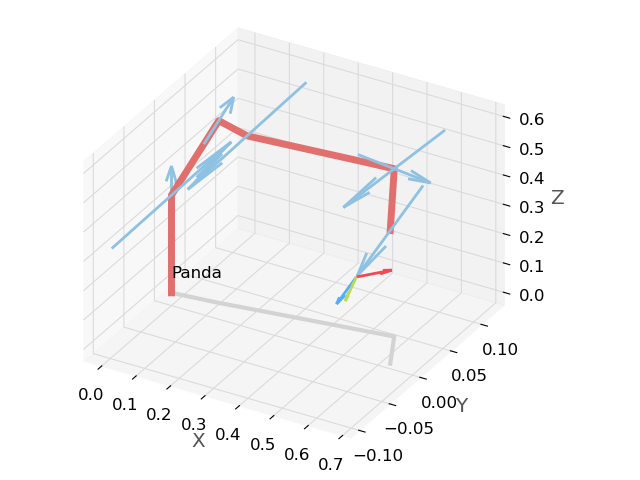

(-0.5, 0.5)

In [16]:
fig = panda.plot(panda.ikine_LM(X_init,q0).q)
ax = fig.ax
x3d = np.vstack((X_init.t, X_final.t))
ax.plot(x3d[:,0],x3d[:,1],x3d[:,2])
x3d = np.array(data.x3d_ruckig)
ax.plot(x3d[:,0],x3d[:,1],x3d[:,2])
x3d = np.array(data_top.x3d_top)
ax.plot(x3d[:,0],x3d[:,1],x3d[:,2],'k')
x3d.shape

ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
ax.set_zlim([-0.5,0.5])